In [19]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import gridspec
from scipy.stats import norm
import energyflow as ef #needed for the Geant4 datasets

In [20]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
import tensorflow.keras.backend as K

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES']="3"
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB


# Config

In [21]:
N = 20000
sigma = 1
mu = 0
epsilon = 2


# colors
n_lines = 5
c = np.arange(-3, n_lines + 1)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap="Blues")
cmap.set_array([])



MSE_color = cmap.to_rgba(3)
MSE_darkcolor = cmap.to_rgba(4)
MLC_color = "red"
MLC_darkcolor = "darkred"
data_color = "black"
capsize = 2

# Data

In [22]:


gauss_truth_prior = np.random.normal(mu,sigma,N)
gauss_reco_prior = np.random.normal(gauss_truth_prior,epsilon,N)
mycalibration = np.polyfit(gauss_reco_prior, gauss_truth_prior, 1)
mypoly = np.poly1d(mycalibration)


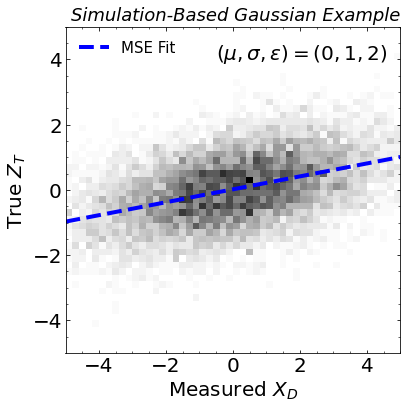

In [23]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

# plt.scatter(gauss_reco_prior,gauss_truth_prior,label="Data",alpha=0.05, color = data_color)
plt.hist2d(gauss_reco_prior,gauss_truth_prior,label="Data", density = True, bins = (50, 50), range = [[-5, 5], [-5, 5]], cmap = "binary")
plt.plot(np.linspace(-5,5,20),mypoly(np.linspace(-5,5,20)),label="MSE Fit",ls="--",color="blue",lw=4)

plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("Measured $X_D$",fontsize=20)
plt.ylabel("True $Z_T$",fontsize=20)
leg = plt.legend(frameon=False,fontsize=15,ncol=1, loc = "upper left")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

_=plt.title(r"Simulation-Based Gaussian Example",loc="right",fontsize=18, fontstyle="italic")
_=plt.text(-0.5,4,r"$(\mu,\sigma,\epsilon)=(0,1,2)$",fontsize=20)
plt.savefig("Gaussian_prior.pdf",bbox_inches='tight')

# GA Fit


Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

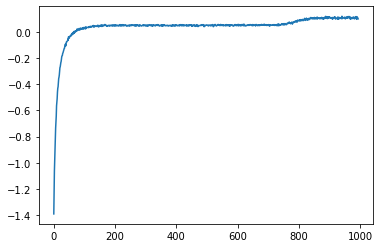

In [39]:

# GA numerical bias
from ifn.Architectures.utils import build_gIFN_DNN
from ifn.Architectures.ifn import IFN, mine_loss, MI
from ifn.Architectures.dnn import DNN
from ifn.Architectures.ifn import IFN, gIFN


x_dim = 1
y_dim = 1
A_layers = [16,16,16]
B_layers = [1,]
C_layers = [1,]
D_layers = [1,]
l2_reg = 1e-9
d_multiplier = 0.0
d_l1_reg = 1e-3


X, Y = np.expand_dims(gauss_reco_prior,1), np.expand_dims(gauss_truth_prior,1)

# # Build model
# ifn = build_gIFN_DNN(1, 1, [16,16,16], l2_reg = 1e-9, acts = 'relu', d_l1_reg= 1e-3, d_multiplier=0)

model_A = DNN(x_dim, A_layers, 1, l2_regs = l2_reg, acts = "relu")
model_B = DNN(x_dim, B_layers, y_dim, l2_regs = l2_reg, acts = "linear")
model_C = DNN([x_dim, y_dim], C_layers, [y_dim, y_dim], symmetrize=True, l2_regs = l2_reg, acts = "relu")
model_D = DNN(x_dim, D_layers, y_dim, l2_regs = l2_reg, acts = "relu")

ifn = gIFN(model_A, model_B, model_C, model_D, d_multiplier= d_multiplier, d_l1_reg = d_l1_reg, y_dim = y_dim)


ifn.pre_train([X, Y], epochs = 10, batch_size = 64, verbose = True)
opt = tf.keras.optimizers.Adam(lr = 1e-3)
ifn.compile(loss=mine_loss, optimizer=opt, metrics = [MI,])


# Fit
history = ifn.fit([X, Y],
            batch_size= 1024,
            epochs = 1000,
            shuffle=True, verbose= 2)

plt.plot(history.history["MI"][5:])

In [40]:
def analytic_bias(x):
    return (sigma**2/(sigma**2+epsilon**2))*x+(epsilon**2/(sigma**2+epsilon**2))*mu


def analytic_bayesian_resolution(x):
    temp = epsilon ** 2 * sigma **2 / ((epsilon**2 + sigma**2 ))
    return np.sqrt(temp)


print(analytic_bayesian_resolution(0))

def analytic_resolution(z):
    return np.sqrt((epsilon**2 *  sigma**4) / ((epsilon**2 + sigma**2 ))**2)

def analytic_MSE(x):
    return (epsilon**2 * mu + sigma**2 * x) / ((epsilon**2 + sigma**2 ))



meanvals_analytic = analytic_bias(np.linspace(-5,5,20))
resvals_analytic = analytic_bayesian_resolution(np.linspace(-5,5,20))    


0.8944271909999159


In [41]:
# Estimates
xrange = np.linspace(-5,5,20)
window = 0.25
MSE_estimates = np.array([mypoly(np.random.normal(xx,2,1000)) for xx in np.linspace(-5,5,20)])
MSE_means = np.mean(MSE_estimates, axis = 1)
MSE_stds = np.std(MSE_estimates, axis = 1)
# meanvals = np.array([np.mean(mypoly(np.random.normal(xx,2,10000))) for xx in np.linspace(-5,5,20)])

sorted_xs = np.sort(gauss_reco_prior)
sorted_indices = np.argsort(gauss_reco_prior)
n = 0
stds = []
for x in xrange:
    m = mypoly(x)
    temp_array = []
    for (index, i) in enumerate(sorted_xs[n:]):
        temp_array.append(gauss_truth_prior[sorted_indices[index]])
        if i > x + window:
            n = index + n
            break
    std = np.std(temp_array)
    stds.append(std)
    


# Plots

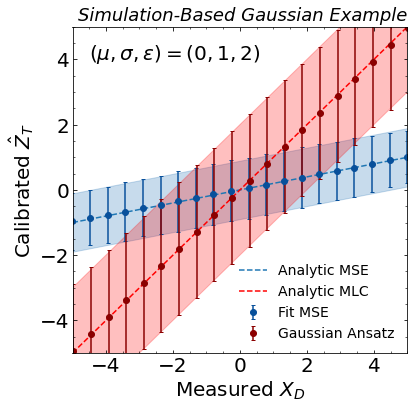

In [42]:
GA_meanvals =  np.squeeze(ifn.maximum_likelihood(np.expand_dims(np.linspace(-5,5,20), 1)))
GA_stds =  np.squeeze(ifn.uncertainty(np.expand_dims(np.linspace(-5,5,20), 1)))


fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()


# # True z_T sample
# plt.scatter(gauss_reco_prior[:2500],gauss_truth_prior[:2500],label="True $Z_T$",alpha=0.05, color = data_color)

# MSE
plt.errorbar(xrange,MSE_means, yerr = stds,marker='o',ls="",label="Fit MSE", color = MSE_darkcolor, capsize = capsize)
plt.fill_between(xrange, meanvals_analytic+resvals_analytic, meanvals_analytic-resvals_analytic, color = MSE_color, alpha = 0.25)
plt.plot(xrange,meanvals_analytic,ls="--",label="Analytic MSE")

# MLC
plt.plot(xrange,np.linspace(-5,5,20),ls="--",label="Analytic MLC", color = MLC_color)
plt.fill_between(xrange, np.linspace(-5,5,20) + epsilon, np.linspace(-5,5,20) -epsilon, color = MLC_color, alpha = 0.25)
plt.errorbar(xrange + 0.025,GA_meanvals, yerr = GA_stds,marker='o',ls="",label="Gaussian Ansatz", color = MLC_darkcolor, capsize = capsize)


plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("Measured $X_D$",fontsize=20)
plt.ylabel("Calibrated $\hat{Z}_T$",fontsize=20)
leg = plt.legend(frameon=False,fontsize=14,ncol=1, loc = "lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1)
_=plt.title("Simulation-Based Gaussian Example",loc="right",fontsize=18, fontstyle="italic")
_=plt.text(-4.5,4,r"$(\mu,\sigma,\epsilon)=(0,1,2)$",fontsize=20)
plt.savefig("Gaussian_prior2.pdf",bbox_inches='tight')

# Multiple Fits

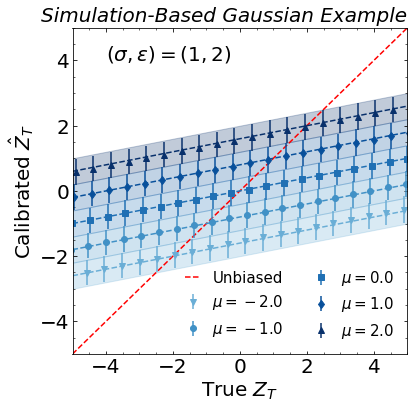

In [43]:
import matplotlib as mpl

def b(x,sigma,epsilon,mu):
    return (sigma**2/(sigma**2+epsilon**2))*x+(epsilon**2/(sigma**2+epsilon**2))*mu


def analytic_resolution(z,sigma, epsilon, mu):
    return np.sqrt((epsilon**2 *  sigma**4) / ((epsilon**2 + sigma**2 ))**2)

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

# colors
n_lines = 5
c = np.arange(-3, n_lines + 1)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap="Blues")
cmap.set_array([])

plt.plot(np.linspace(-5,5,20),np.linspace(-5,5,20),ls="--",label="Unbiased",color="red")
markers = ["v","o","s","d","^"]
myc=-1
for (i,epsilon) in enumerate(np.linspace(-2,2,5)):
    myc+=1
    gauss_truth_prior_B = np.random.normal(epsilon,1,10000)
    gauss_reco_prior_B = np.random.normal(gauss_truth_prior_B,2,10000)
    mycalibration_B = np.polyfit(gauss_reco_prior_B, gauss_truth_prior_B, 1)
    mypoly_B = np.poly1d(mycalibration_B)

    meanvals_B = np.array([np.mean(mypoly_B(np.random.normal(xx,2,10000))) for xx in np.linspace(-5,5,20)])
    meanvals_analytic_B = b(np.linspace(-5,5,20),1,2,epsilon)
    resvals_analytic_B = analytic_resolution(np.linspace(-5,5,20),1,2,epsilon)

    plt.errorbar(np.linspace(-5,5,20) + epsilon / 20,meanvals_B, yerr = MSE_stds, marker=markers[myc],ls="",color=cmap.to_rgba(i + 1),label="$\mu=%0.1f$" % epsilon)
    plt.plot(np.linspace(-5,5,20),meanvals_analytic_B,ls="--",color=cmap.to_rgba(i + 1))
    plt.fill_between(np.linspace(-5, 5, 20), meanvals_analytic_B + resvals_analytic_B, meanvals_analytic_B - resvals_analytic_B, color = cmap.to_rgba(i + 1), alpha = 0.25)

plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("True $Z_T$",fontsize=20)
plt.ylabel("Calibrated $\hat{Z}_{T}$",fontsize=20)
plt.legend(frameon=False,fontsize=15,ncol=2,loc="lower right",handlelength=1)
_=plt.title("Simulation-Based Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
_=plt.text(-4,4,r"$(\sigma,\epsilon)=(1,2)$",fontsize=20)
plt.savefig("Gaussian_prior4.pdf",bbox_inches='tight')


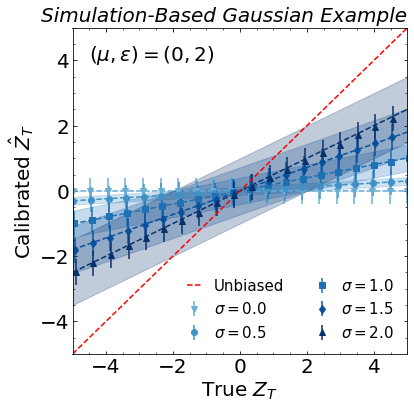

In [44]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)

ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

# colors
n_lines = 5
c = np.arange(-3, n_lines + 1)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap="Blues")
cmap.set_array([])

markers = ["v","o","s","d","^"]
myc=-1
for (i,sigma) in enumerate(np.linspace(0.01,2,5)):
    myc+=1
    gauss_truth_prior_B = np.random.normal(0,sigma,10000)
    gauss_reco_prior_B = np.random.normal(gauss_truth_prior_B,2,10000)
    mycalibration_B = np.polyfit(gauss_reco_prior_B, gauss_truth_prior_B, 1)
    mypoly_B = np.poly1d(mycalibration_B)

    meanvals_B = np.array([np.mean(mypoly_B(np.random.normal(xx,2,10000))) for xx in np.linspace(-5,5,20)])
    meanvals_analytic_B = b(np.linspace(-5,5,20),sigma,2,0)
    resvals_analytic_B = analytic_resolution(np.linspace(-5,5,20),sigma,2,0)

    plt.errorbar(np.linspace(-5,5,20) + sigma / 20,meanvals_B, yerr = MSE_stds, marker=markers[myc],ls="",color=cmap.to_rgba(i + 1),label="$\sigma=%0.1f$" % sigma)
    plt.plot(np.linspace(-5,5,20),meanvals_analytic_B,ls="--",color=cmap.to_rgba(i + 1))
    plt.fill_between(np.linspace(-5, 5, 20), meanvals_analytic_B + resvals_analytic_B, meanvals_analytic_B - resvals_analytic_B, color = cmap.to_rgba(i + 1), alpha = 0.25)

plt.plot(np.linspace(-5,5,20),np.linspace(-5,5,20),ls="--",label="Unbiased",color="red")

plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("True $Z_T$",fontsize=20)
plt.ylabel("Calibrated $\hat{Z}_{T}$",fontsize=20)
plt.legend(frameon=False,fontsize=15,ncol=2,loc="lower right",handlelength=1)
_=plt.title("Simulation-Based Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
_=plt.text(-4.5,4,r"$(\mu,\epsilon)=(0,2)$",fontsize=20)
plt.savefig("Gaussian_prior3.pdf",bbox_inches='tight')